In [34]:
import numpy as np
import validation as validation
import algebra as algebra

In [35]:
#########################################################################
#  Operators
#  Each operator must be a class with forward and transpose methods
###########################################################################

class zero_op:
    """
        Returns 0
    """
    def forward(self,x):
        return 0.0
    def transpose(self,x):
        return 0.0

class matrix_op:
    """
        matrix_op(A) converts the matrix A to a matrix 
        operator and its transpose
    """
    def __init__(self,A):
        self.A=A
        
    def forward(self,x):
        return np.matmul(self.A,x)
    
    def transpose(self,x):
        return np.matmul(np.transpose(self.A),x)
    
    
class scalar_prod_op:
    """
       scalar_prod(a) is the scalar product with a
    """
    def __init__(self,a):
        self.a=a
        
    def forward(self,x):
        return self.a*x
    
    def transpose(self,x):
        return self.forward(x)
    
class hadamard_op:
    """
       Hadamard product. Multiply every entry of 
       x with the corresponding entry of A
    """
    def __init__(self,A):
        self.A=A
    def forward(self,x):
        return self.A*x
    def transpose(self,x):
        return self.forward(x)
    
class real_fftn_op:
    """
        FFT of real valued vectors and matrices
    """
    def forward(self,x):
        return np.fft.fftshift(np.fft.fftn(np.real(x)))
    def transpose(self,x):
        return np.real(np.fft.ifftn(np.fft.ifftshift(x)))


class real_imag_fftn_op:
    """
        FFT of a real+ imag vector or matrix
    """
    def forward(self,x):
        return algebra.complex2array(np.fft.fftshift(np.fft.fftn(algebra.array2complex(x))))
    def transpose(self,x):
        return algebra.complex2array(np.fft.ifftn(np.fft.ifftshift(algebra.array2complex(x))))


class fftn_op:
    """
        FFT of complex valued vectors and matrices
    """
    def forward(self,x):
        return np.fft.fftshift(np.fft.fftn(x))
    def transpose(self,x):
        return np.fft.ifftn(np.fft.ifftshift(x))
    
    
class composite_op:
    """
       Creates a composite operator 
       Uses mathematical notation
       That is, composite_op(A,B,C) is the operator ABC, i.e. C operates first
       followed by B followed by A
       composite_op accepts any number of operators as arguments
    """
    def __init__(self,*ops):
        self.ops=ops
        
    def forward(self,x):
        for op in reversed(self.ops):
            x=op.forward(x)
        return x
    
    def transpose(self,x):
        for op in self.ops:
            x=op.transpose(x)
        return x

    
class add_op:
    """
        Creates a sum operator
        e.g. add_op(A,B,C) gives the operator A+B+C
    """
    def __init__(self,*ops):
        self.ops=ops

    def forward(self,x):
        y=0
        for op in self.ops:
            y += op.forward(x)
        return y
    
    def transpose(self,x):
        y=0
        for op in self.ops:
            y += op.transpose(x)
        return y   

In [36]:
##########################################################
#  Utility functions for conjugate gradient
##########################################################

def inner_prod(x,y):
    """
        real and complex inner product
        Works for vectors and matrices
    """
    return np.real(np.sum(np.conj(x)*y))

def norm_sq(x):
    """
        Euclidean norm sq for vectors
        Frobenius norm sq for matrices
        Works for real and complex
    """
    return inner_prod(x,x)

def norm(x):
    """
        Euclidean norm for vectors
        Frobenius norm for matrices
        Works for real and complex
    """
    return np.sqrt(norm_sq(x))
    
            
def lhs_op(A,B):
    """
        Creates the operator on the LHS of the CG linear equation
        i.e. creates (A^TA+B^TB)
    """
    def lhs(x):
        return A.transpose(A.forward(x))+B.transpose(B.forward(x))
    return lhs
    
##################################################################
#    Conjugate gradient minimization with L2 regularization
##################################################################
    
def c_grad(y,A,x,B=zero_op(),max_iter=100,f_tol=1e-5):
    """
     Conjugate gradient algorithm for minimizing ||y-Ax||^2 + ||Bx||^2
     The second term is a regulizer, and is optional
     The termination criteria are
         either k=num_steps >= max_iter 
         or ||y-Ax||<= f_tol*||y|| (Scipy criterion)
         
    The minimizer is found by solving the linear equation
            (A^TA + B^TB)x=A^Ty
    
    Inputs: y,A,B as defined by the objective function above. A and B
                 have to be operators with forward and transpose defined
            max_iter: maximum number of iterations
            f_tol: as defined above
    
    Output: tuple (x,flag)
        where x is the solution
             flag=1 if max_iter are reached, else 0
    """
    # Mathematical comments below correspond to Wikipedia CG formulae
    # written in Latex
    # See https://en.wikipedia.org/wiki/Conjugate_gradient_method
    
    A_star=lhs_op(A,B) #A_star is the operator A^*=(A^TA + B^TB)
    b=A.transpose(y)  #A^Ty
    r_k=b-A_star(x)
    p_k=r_k
    x_k=x
    #initialize iteration
    k=0
    t=f_tol*norm(b)
    res_norm_sq=norm_sq(r_k)
    while ((k<max_iter) & (np.sqrt(res_norm_sq)>=t)):
        AtAp=A_star(p_k) #Precalculate to save flops
        alpha_k= res_norm_sq/inner_prod(p_k,AtAp) # alpha_k = r^T_kr_k/p^T_k A^*p_k
        x_k1=x_k+alpha_k*p_k                      # x_{k+1}=x_k+\alpha_k p_k
        r_k1=r_k-alpha_k*AtAp                     # r_{k+1}= r_{k}-\alpha_k A^*p_k
        beta_k=norm_sq(r_k1)/res_norm_sq          # \beta_k = r^T_{k+1}r_{k+1}/r^T_kr_k
        p_k1=r_k1+beta_k*p_k                      # p_{k+1}= r_{k+1}+\beta_k p_k
        #update
        k=k+1
        x_k=x_k1
        p_k=p_k1
        r_k=r_k1
        res_norm_sq=norm_sq(r_k)
        print(f"CG: step={k} res_norm={np.sqrt(res_norm_sq)} ")
    return x_k,k>=max_iter
        

### Test 1: Simple test without noise
#### The operator A is (MO+R). Task is to recover a vector. No regularization on CG

In [37]:
M=matrix_op(np.array(((1, 2, 3),(0, 1, 0),(2, 3,1))))
O=scalar_prod_op(2.0)
R=scalar_prod_op(0.1)
A=add_op(composite_op(M,O),R) 

x=np.array((1,0.5,1)).reshape(-1,1) #Input x
y=A.forward(x) #Create noiseless output by applying A
print(f"x={x}\n y={y}")

x0=np.zeros_like(x) #Initial value for CG
x_cg,flag=c_grad(y,A,x0)
print(f"x={x_cg} \n flag={flag}")
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.1)

x=[[1. ]
 [0.5]
 [1. ]]
 y=[[10.1 ]
 [ 1.05]
 [ 9.1 ]]
CG: step=1 res_norm=3.234651420766811 
CG: step=2 res_norm=0.7480204131885724 
CG: step=3 res_norm=6.8985257123446856e-12 
x=[[1. ]
 [0.5]
 [1. ]] 
 flag=False
Original and CG are equal in absolute value


### Test 2: x is matrix, y contains noise, CG uses regularizer

In [38]:
M=matrix_op(np.array(((1, 2, 3),(0, 1, 0),(2, -3,1))))
O=scalar_prod_op(2.0)
R=scalar_prod_op(0.1)

A=add_op(composite_op(M,O),R)

x=np.transpose(np.array(((1,0.5,1),(0,1,0))))
y=A.forward(x)
y=y+0.1*np.random.normal(size=y.shape)
print(f"x={x}\n y={y}")

x0=np.zeros_like(x)
x_cg,flag=c_grad(y,A,x0,B=R,f_tol=1e-8)
print(f"x={x_cg} \n flag={flag}")
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.1)

x=[[1.  0. ]
 [0.5 1. ]
 [1.  0. ]]
 y=[[10.10805704  4.07876417]
 [ 1.07846026  2.19514709]
 [ 3.26788615 -5.89732614]]
CG: step=1 res_norm=8.266345899225124 
CG: step=2 res_norm=0.3506766525666233 
CG: step=3 res_norm=2.339318167611582e-13 
x=[[ 1.07282549  0.11837938]
 [ 0.51009002  1.04215   ]
 [ 0.96898915 -0.05636509]] 
 flag=False
Original and CG are not equal in absolute value


### CG with real fft

In [39]:
x=np.random.normal(size=(4,4))
print(x)
A=real_fftn_op()
y=A.forward(x)
y=y+0.2*np.random.normal(size=y.shape)
#print(f"x={x}\n y={y}")
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R)

print(x_cg)
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.1)

[[ 1.05957924 -0.86807474 -0.6850073  -3.15064421]
 [-0.13167066 -0.04725204 -0.28993875 -0.61678077]
 [ 0.64123439 -0.40767825  0.20770128 -0.50864083]
 [ 0.88170909 -1.56520478  0.6354185  -0.67934567]]
x=[[ 1.05957924 -0.86807474 -0.6850073  -3.15064421]
 [-0.13167066 -0.04725204 -0.28993875 -0.61678077]
 [ 0.64123439 -0.40767825  0.20770128 -0.50864083]
 [ 0.88170909 -1.56520478  0.6354185  -0.67934567]]
CG: step=1 res_norm=6.131431598003248e-16 
[[ 1.05582606 -0.86151655 -0.68343842 -3.12148632]
 [-0.15075778  0.00604931 -0.2997468  -0.62865941]
 [ 0.62049973 -0.45414239  0.2485193  -0.55410534]
 [ 0.8525885  -1.56769308  0.6164485  -0.61978596]]
Original and CG are not equal in absolute value


### CG with complex fft


In [40]:
x=np.random.normal(size=(4,4))
A=fftn_op()
y=A.forward(x)
y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R)

print(f"abs(x_cg)={abs(x_cg)}")
validation.validate_equal(x, x_cg, "Original", "CG", rtol=0.5)
print(f"angle(x_cg)={np.angle(x_cg)}")

x=[[-0.87186145  1.19516122 -0.77463246 -0.15659466]
 [ 0.32764637  0.07758987  0.43708618 -0.97888652]
 [-0.58979979  0.8335053  -0.27711091  1.41889704]
 [ 0.84113011 -2.25870093 -1.23798199  1.55384551]]
CG: step=1 res_norm=7.109738799716153e-16 
abs(x_cg)=[[0.88538527 1.22069164 0.78338222 0.1297717 ]
 [0.33205515 0.07516742 0.44961751 0.92151846]
 [0.54015632 0.86766258 0.32726714 1.44646422]
 [0.84009925 2.1886534  1.21426225 1.53680571]]
Original and CG are equal in absolute value
angle(x_cg)=[[ 3.14159265e+00 -4.27978296e-02  3.14159265e+00  2.72739785e+00]
 [ 5.95103021e-02  5.18019091e-03  1.32520156e-01  3.13610411e+00]
 [ 3.14159265e+00 -6.76118311e-02  3.14159265e+00  4.05372126e-02]
 [-2.35101511e-02 -3.13928175e+00 -3.09264699e+00 -2.53369601e-04]]


x=[[ 0.52788105 -0.72238022  1.11734449  1.35361497  0.          0.
   0.          0.        ]
 [ 0.58391506 -0.31500081  0.03918265 -0.97938482  0.          0.
   0.          0.        ]
 [ 1.38332965  0.81537958  1.89616748 -1.67111428  0.          0.
   0.          0.        ]
 [ 0.51749342 -0.15008362  1.90529917  1.75145393  0.          0.
   0.          0.        ]]
CG: step=1 res_norm=8.299039534176223e-16 
CG: step=2 res_norm=1.536006268625138e-31 
CG: step=3 res_norm=2.5934536643094847e-47 
CG: step=4 res_norm=6.12595282061835e-63 
abs(x)=[[0.52788105 0.72238022 1.11734449 1.35361497]
 [0.58391506 0.31500081 0.03918265 0.97938482]
 [1.38332965 0.81537958 1.89616748 1.67111428]
 [0.51749342 0.15008362 1.90529917 1.75145393]]
abs(x_cg)=[[0.61999123 0.69742034 1.13802495 1.32261062]
 [0.57076079 0.31502683 0.07499    1.05149852]
 [1.33169101 0.8682799  1.94832876 1.67441243]
 [0.59292626 0.1316483  1.75754503 1.66160166]]
Original and CG are equal in absolute value


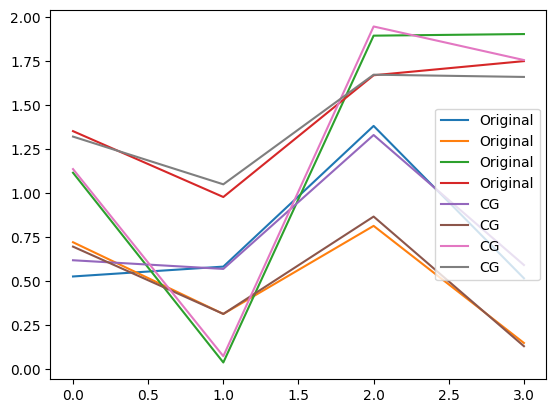

angle(x_cg)=[[-0.00558573 -3.05829596  0.02220456  0.00737697]
 [ 0.10043788  3.0871616  -0.45623561 -3.11046271]
 [-0.01224438  0.00341091 -0.06206725 -3.11000189]
 [ 0.1247881  -2.94641258  0.02110588 -0.02260394]]


In [48]:
x_size = (4,4)
x=np.random.normal(size=x_size)
x = algebra.complex2array(x)
A=real_imag_fftn_op()
y=A.forward(x)
y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R, f_tol=1e-50)

x_comp = algebra.array2complex(x)
x_cg_comp = algebra.array2complex(x_cg)

print(f"abs(x)={abs(x_comp)}")
print(f"abs(x_cg)={abs(x_cg_comp)}")
validation.validate_equal(x_comp, x_cg_comp, "Original", "CG", rtol=0.5, make_plot=True)
print(f"angle(x_cg)={np.angle(x_cg_comp)}")

x=[[-9.15435920e-01  1.75467323e+00  4.99161961e-01  3.11549712e-01
   7.84623753e-01  1.33464464e+00 -2.66155743e-02 -1.52941633e+00]
 [-1.30982435e+00  1.09325896e+00  2.13524112e-01 -9.12945326e-01
  -6.94238569e-01  2.14945306e+00  4.95173636e-01 -6.51268992e-02]
 [ 1.20535569e+00 -5.37239829e-01 -5.16062511e-01  1.48090426e+00
   6.94209595e-01  1.57216892e+00 -4.15620539e-01  8.09813143e-01]
 [-1.52998242e+00 -4.93865387e-01  2.67815143e-01  7.61154667e-01
  -8.49582033e-05  8.25039636e-01  1.78753243e-01  1.41119861e+00]]
CG: step=1 res_norm=7.39572250339014e-16 
CG: step=2 res_norm=1.6386397546663475e-31 
CG: step=3 res_norm=5.102078188661746e-47 
CG: step=4 res_norm=1.9999315831359783e-62 
abs(x)=[[1.20567714 2.2045758  0.49987104 1.56082592]
 [1.4824328  2.4115065  0.53924899 0.91526536]
 [1.39097423 1.66142763 0.66261674 1.687861  ]
 [1.52998242 0.96155781 0.32199017 1.60338328]]
abs(x_cg)=[[1.19580169 2.24110047 0.49117765 1.50088767]
 [1.45235429 2.33440836 0.51492828 0.93

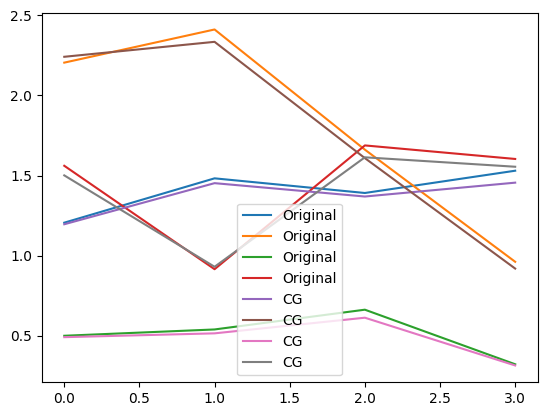

angle(x)=[[ 2.4329888   0.65026517 -0.05327007 -1.36984085]
 [-2.6542152   1.10027499  1.16367704 -3.07037617]
 [ 0.52253858  1.90007481 -2.46358674  0.50041151]
 [-3.14153712  2.1101828   0.58854478  1.0761529 ]]
angle(x_cg)=[[ 2.35026581  0.65557125 -0.06619494 -1.36988505]
 [-2.70347352  1.08675942  1.21860824  3.12618671]
 [ 0.53836139  1.86104593 -2.37786015  0.46807151]
 [-3.09472472  2.1197241   0.68330984  1.10313111]]


In [49]:
x_size = (4,4)
x=np.random.normal(size=x_size)+1j*np.random.normal(size=x_size)
x = algebra.complex2array(x)

A=real_imag_fftn_op()
# y=A.forward(x)
B = fftn_op()
y = algebra.complex2array(B.forward(algebra.array2complex(x)))
y=y+0.2*np.random.normal(size=y.shape)
print(f"x={x}")

x0=np.zeros_like(x)
R=scalar_prod_op(0.1)
x_cg,_=c_grad(y,A,x0,B=R, f_tol=1e-50)

x_comp = algebra.array2complex(x)
x_cg_comp = algebra.array2complex(x_cg)

print(f"abs(x)={abs(x_comp)}")
print(f"abs(x_cg)={abs(x_cg_comp)}")
validation.validate_equal(x_comp, x_cg_comp, "Original", "CG", rtol=0.5, make_plot=True)
print(f"angle(x)={np.angle(x_comp)}")
print(f"angle(x_cg)={np.angle(x_cg_comp)}")